<a href="https://colab.research.google.com/github/mds9b/Stats-Project-1/blob/main/TheGerrymanderProject_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gerrymandering Project**

**Project Statement**


The following project represents a collaborative effort to explore dynamic programming through the problem of gerrymandering. Namely, our team sought to determine wehther gerrymandering is possible. For each precinct, which is comprised of a number of districts, there will be some fraction which votes for party A (e.g. Republican), Party B (e.g. Democrat), or other (e.g. independent). 

---

*UVA CS 5012, August 2021*


Alexander DeLuca, mcg4aw@virginia.edu

Kelly Farrell, knf7vg@virginia.edu

Samy Kebaish, sak3qf@virginia.edu

Grant Redfield, tnx7bh@virginia.edu

Matthew Sachs, mds9b@virginia.edu

Anita Taucher, agt4vw@virginia.edu

## Introduction

***Gerrymandering***


The etymology of gerrymandering is a portmanteau of Gerry and Mander. The former refers to the former Vice President of the United States, Gerry Eldridge; the latter is based on a drawing by Elkanah Tisdale, who redrew the map of the district akin to a monster, as an exaggeration of the seemingly unnatural shapes of the voting district. A dinner guester remarked its similarity to a salamnder, to which Richard Alsop replied, "[No, a] Gerry Mander"The name was derived during Gerry Eldridge's appointment as the Governor of Massachusetts. Specifically, in 1812, Massachusetts had devised and adopted electoral district boundaries under the auspices of new legislation. However, the Republican party held the State Senate Majority, and devised the distrct lines to improve their control over legislative districts. Consequently, in order to satisfy their capture of the majority, the Republican part drew the district lines such that a majority of Republican voters were present.

***Dynamic Programming***

In order to determine whether gerrymandering is possible for a particular district, our team constructed a dynamic programming algorithm. In particular, a greedy algorithm was used, in which a sequence of choices are made, and each choice selects the optimal heuristic at that step (the optimal or "best" choice representing the greedy component). Some publications have refferred to four greedy principles: 



1.   Best-Global: a partial solution is considered which is best with respect to local optimality criterion; optimality is only guaranteed for completed solutions
2.   Better Global: similar to best, but stronger, in the sense that, in a situation with two partial solutions, the first that is better than the second is selected. 
3.   Best Local: during the running of the alogirthm, the partial solution that is the best thus far, with respect to the local optimality criterion, remains the best after applying the greedy step. 
4.   Better Local: the strongest of the four principles, in which, given the result of a construction step on the second, there is a way of performing a construction step on the first that is at least as good with respecct to the local optimality criterion. 


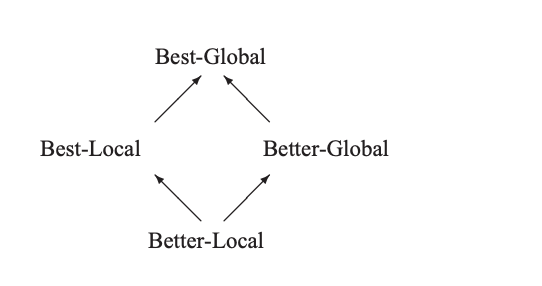


References: https://www.smithsonianmag.com/history/where-did-term-gerrymander-come-180964118/

https://core.ac.uk/download/pdf/82042073.pdf

## The Problem

## The Data

Voter Registration data by precinct and district is maintained by states.  There is not a central federal database that tracks the state breakdowns and voter registrations.  This makes sense because voting is executed by each state, and they have leeway to maintain voting data as they see necessary; but it makes our goal a little more difficult to reach.

Not all states maintain voter registration data by party.  In fact, not all states require a party declaration for voters during registration.

For the scope of our project, we have chosen to target states where data is available with the following breakdown:

* Precinct

* District

* Registered Republicans

* Registered Democrats


### Storage
For data storage and retrieval we are using SQLite.  Here, we establish a connection to the database and define a cursor to be used throughout the project.

In [ ]:
import sqlite3 # https://docs.python.org/3/library/sqlite3.html
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats  as stats
import math
import numpy as np

## Establish a connection to our database
conn = sqlite3.connect('gerrymander.db')

## Create a cursor to execute commands through the connection
cursor = conn.cursor()


### Redeploy the Database every time

To make it easier to rebuild and deploy to new environments, we have provided a "recreate" flag.  When recreate is True, we drop existing tables and recreate them from scratch.  We also prefer to recreate for an easier delivery of the .ipynb file; anyone can deploy the entire database on their preferred notebook platform.

Our approach for inserting data is efficient and fast, so rebuilding is clean, quick, and easy.

In [ ]:
## When recreate is True, we drop all database tables and recreate them for an updated, clean deployment.

recreate = True

if recreate == True:

  cursor.execute("DROP TABLE IF EXISTS precinct")
  cursor.execute("DROP TABLE IF EXISTS party")
  cursor.execute("DROP VIEW IF EXISTS for_algo")
  conn.commit()

  # Quick verification to make sure everything was dropped
  cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
  cursor.fetchall()



### Talk to GitHub
We store the scripts for building the database, including the data and schema, in a github repository.  We are using python's urllib3 library to communicate over https.  In this step, as required by urllib3, we define a pool manager to communicate over https with our github repo.

In [ ]:
## Our SQL Scripts are in Github
## prepare to read from github
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

gitread = urllib3.PoolManager()


# *Parameters Used*

Prior to data procurement, we needed to develop a team-wide understanding of the requisite algorithmic inputs. This paradigm allowed us to set a minimum data standard for all state data sets; the lack of a federal database necessitated a state-first approach. With Brittanica defining gerrymandering as “the practice of drawing the boundaries of electoral districts in a way that gives one political party an unfair advantage over its rivals”, we could safely conclude that we needed district level data and their composite precincts. These district and precinct variables configure the boundary, and along with Democratic and Republican voter counts, are the primary inputs we need.Democrat and Republican voters counts represent a topic worthy of further discussion. Though the American political system is largely defined by extreme bipartisanship, there are various third parties with significant registration numbers and voter turnouts. However, since these various third parties do not have the political heft nor the voter base to indulge in gerrymandering, they can be safely removed from consideration in the algorithm. From a data standpoint, this means we only need Democrat and Republican counts with their cumulative total.The real point of contention revolved around whether to use voter registrationnumbers or voter turnout numbers. The consensus was that, in heavily red or heavily blue precincts, having the outcome as a foregone conclusion could introduce a biased suppressant of voter turnout. This inclination is widely supportedby research, “there is far greater variation in primary election turnout rates, depending on how many seriously contested races are on the ballot”. Due to this difficult-to-account for bias, we thought registration numbers were a more apt depiction of a precinct’s voting potential. There was a downside to this, unfortunately. Although there was a wealth of voter turnout data, voter registration data was far sparser and not consistently compiled state to state.

**Parameters**


n = number of individuals per *precinct*


Given: 
M - Number of People Per Precinct 
$A_{1}$, $A_{2}$, ... $A_{n}$ where A 


Output: 2 districts, |$D_{1}$|, |$D_{2}$|

1. Where |$D_{1}$| = |$D_{2}$|, i.e. The same number of precincts. 

2. 
We want to determine whether A has a majority in both districts, i.e. the total number of people divided by four

A($D_{1}$) > m * n/4 

A($D_{2}$) > m * n /4 i.e. 

**Algorithm Schema**

 $S_{j}$,$_{k}$,$_{x}$,$_{y}$ =  $S_{j-1}$,$_{k-1}$,$_{x-A_j}$,$_{y}$ 





```
for j =1 to n
  for k = 1 to n/2
    for x = 1 to m*j 
      for y = 1 to m*j
      
```




 $S_{j}$,$_{k}$,$_{x}$,$_{y}$ = there is a split of first j precincts in which |𝐷1| = k and x people in D1 vote A and y people in D2 vote A 


# Gerrymandering Algorithm (code)

In [ ]:
class NDSparseMatrix:
  def __init__(self):
    self.elements = {}

  def addValue(self, tuple, value):
    self.elements[tuple] = value

  def readValue(self, tuple):
    try:
      value = self.elements[tuple]
    except KeyError:
      value = 0
    return value


SuperMatrix = NDSparseMatrix()
SuperMatrix.addValue((0,0,0,0), 1)


def GerryManderingIdentifier(df):
    Percent_Done_List = ["25", "50", "75"]
    i = 0
    Number_of_Precincts = len(df.index) - 1
    Total_Votes = df['Total_Votes'].sum().astype(int)
    Half_Precincts = math.ceil(Number_of_Precincts/2)
    Total_Matrix_Size = Number_of_Precincts * Number_of_Precincts * Total_Votes * Total_Votes
    count = 0
    Percent_Done = .25 * Total_Matrix_Size
    for j in range(1, Number_of_Precincts + 1):
        for k in range(1, Number_of_Precincts + 1):
            for x in range(0, Total_Votes + 1):
                for y in range(0, Total_Votes + 1):
                    count = count + 1
                    if count > Percent_Done and i < 3:
                      print(Percent_Done_List[i],"% Done")
                      Percent_Done = Percent_Done + (.25 * Total_Matrix_Size)
                      i = i + 1
                    if SuperMatrix.readValue((j - 1,k - 1, x - df['REP_VOTES'][j],y)) == 1 or SuperMatrix.readValue((j - 1,k,x,y - df['REP_VOTES'][j])) == 1:
                        SuperMatrix.addValue((j, k, x, y), 1)  
                    if j == (Number_of_Precincts) and k == (Half_Precincts) and x > Total_Votes/4 and y > Total_Votes/4 and SuperMatrix.readValue((j, k, x, y)) == 1:
                        print("final J", j)
                        print("final K", k)
                        print("final X", x)
                        print("final Y", y)
                        return True
                        break
    return False








**Algorithmic Analysis**

In terms of time complexity, due to the series of nested loops, the run-time is approximately O($n^4m^2$). As can be seen in the interactive graph belows, the algorithm is bound primarily by the quartic term: n^4.That is, when plotting just $n^4$ against $m^2$, the regression for the ($n^4$) terms dwarfs that of the $m^2$ term. Then, in the second graph, the dot product, $n^4m^2$, is compared against $n^4$ against $m^2$, respectively, which takes a far greater runtime than the n and m terms on their own, respectively.  This is explained by the combinatorial product of each step of the algorithm, which is O(n) in the first step, O(n) in the second step, O(m*n) in the second step, and O(m*n) in the third step. 

1. O(n)
2. O(n)
3. O(m*n) 
4. O(m*n) 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


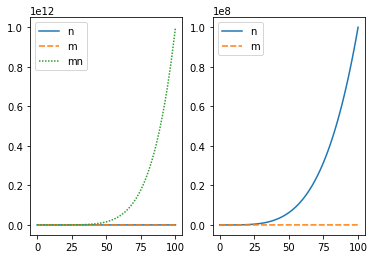

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


n_terms = list(range(0, 101))
m_terms = list(range(0,101))

n_terms_to_the_fourth = np.array([x**4 for x in n_terms])
m_terms_to_the_second = np.array([y**2 for y in m_terms])



def time_complexity_conversion(n_arr, m_arr): 
  
  i = 0

  m_n_list = []

  while i < len(n_arr):
    m_n_term = n_terms_to_the_fourth[i] * m_terms_to_the_second[i]
    m_n_list.append(m_n_term)

    i+=1 

  return m_n_list


m_n_terms = np.array(time_complexity_conversion(n_terms, m_terms))

df = pd.DataFrame({'n': n_terms_to_the_fourth, 'm': m_terms_to_the_second, 'mn': m_n_terms})
df_2 = pd.DataFrame({'n': n_terms_to_the_fourth, 'm': m_terms_to_the_second})

fig, ax =plt.subplots(1,2)
sns.lineplot(data = df, ax=ax[0])
sns.lineplot(data = df_2, ax=ax[1])
fig.show()



Example Dataset to Test GerryMandering

In [ ]:
precinct_data = pd.DataFrame()
precinct_data = precinct_data.append(pd.DataFrame({"Presinct":"DUMMY ROW","District": 0,"REP_VOTES":0, "DEM_VOTES": 0, "Total_Votes": 0},index=[0]))
precinct_data = precinct_data.append(pd.DataFrame({"Presinct":"1-99092","District": 1,"REP_VOTES":65, "DEM_VOTES": 35, "Total_Votes": 100},index=[0]))
precinct_data = precinct_data.append(pd.DataFrame({"Presinct":"1-99093","District": 1,"REP_VOTES":60, "DEM_VOTES": 40, "Total_Votes": 100},index=[0]))
precinct_data = precinct_data.append(pd.DataFrame({"Presinct":"1-99094","District": 2,"REP_VOTES":45, "DEM_VOTES": 55, "Total_Votes": 100},index=[0]))
precinct_data = precinct_data.append(pd.DataFrame({"Presinct":"1-99095","District": 2,"REP_VOTES":47, "DEM_VOTES": 53, "Total_Votes": 100},index=[0]))
precinct_data.reset_index(inplace = True)    
precinct_data.drop('index',axis=1,inplace=True)



LetsRun = GerryManderingIdentifier(precinct_data)

if LetsRun:
    print("GerryMandering is possible")
else:
    print("GerryMandering is not possible")




25 % Done
50 % Done
75 % Done
final J 4
final K 2
final X 110
final Y 107
GerryMandering is possible


# *Where Did We Get The Data*

We ultimately opted for data across 5 states: Alaska, Arizona, Kentucky, North Carolina, and Rhode Island. A more pervasive data breadth would have theoreticallyunlocked more dynamic visualization tools, like a Heroku-hosted Python application,but the algorithm’s speed performance precluded any such need. We explore our individual data sets below.Alaska’s data was procured from the state of Alaska’s elections site, where the data is updated as of August 3. The format is quite amenable to data scraping and was fairly granular in the party breakdown, arranged in a wide format.

Arizona’s data was neatly handed to us at the project kickoff and taken directly from Kaggle—with the caveat that is slightly more dated data from Q1 2019. Interestingly, this data is presented in a long format and requires data reshaping/preprocessing. We also noticed that the party labels are (unsurprisingly) inconsistent state to state.Kentucky’s data set was downloaded in PDF from their state election site and is updated as of July 15. The data is presented in a wide format and the party labels largely mirror that of Arizona’s data set. This dataset is supplemented with gender stratifications, which makes it an interesting candidate for further projects.For North Carolina, the data is organized in long format.Data for Rhode Island is in a long format and largely stripped of the granularity of the preceding datasets. Party identification labels are different and lumped into three categories, “Republican”, “Democrat”, and “Unaffiliated”. The accuracy of this“unaffiliated” group comes into question and epitomizes the bipartisan political lensthat drives most of the United States. As such, Rhode Island would likely represent the minimum state data collected and restrict any downstream analysis.

### Build the tables

In this step we build the schema structure.  The create statements are stored in scripts in github, so this section shows executing the contents of the tables.sql script that we read from github.

We have two tables in our schema:  
*  Precinct:  Holds all data for precincts, districts, and number of voter registrations by party.  There is a row for every party in each precinct, so precinct is not a unique key.  Additionally, within states, precinct is not unique, it must be used with district.

* party:  An id and party name, just to keep the party data consistent within our database - party names and abbreviations change between states, but here we want them to be consistent.  Party can be joined with precinct on precinct.party = party.id


In [ ]:
## Build the table structure
## We have two tables:  party and precinct

## The github url for the tables script
create_tables = 'https://raw.githubusercontent.com/Sartire/gerrymander/main/State_Data/tables.sql'

## GET contents of the tables.sql script from github
dat = gitread.request("GET", create_tables)

## Execute the table creation commands 
cursor.executescript(dat.data.decode("utf-8"))

## Preprocess for algorithm to use
view_def = ''' 
CREATE VIEW for_algo AS
SELECT * FROM
((SELECT STATE, PRECINCT, DISTRICT, VOTERS as REP_VOTES
FROM precinct WHERE PARTY = 'REP') NATURAL JOIN (
SELECT STATE, PRECINCT, DISTRICT, SUM(VOTERS) as Total_Votes
FROM precinct
WHERE PARTY = 'REP' OR PARTY = 'DEM'
GROUP BY STATE, PRECINCT, DISTRICT))
'''
    
cursor.execute(view_def)


## Commit Schema Changes
conn.commit()

## Let's see the names of the tables we built
ourtables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")

if ourtables:
  print('\nTables in the Gerrymander Database\n')
  for atable in ourtables:
    print("\t"+atable[0])



Tables in the Gerrymander Database

	precinct
	party


In [ ]:
sql = '''
SELECT * from for_algo
'''
Arizona = pd.read_sql_query(sql, conn)
print(Arizona)

Empty DataFrame
Columns: [STATE, PRECINCT, DISTRICT, REP_VOTES, Total_Votes]
Index: []


### Arizona

Here, we load the data from Arizona into our database.  The data is from Kaggle, and was suggested as our "stake in the sand" data.  Since Arizona's data had an entry for every party for each precinct, all of our data will follow the same format, no matter its original layout.

[Arizona Data on Kaggle](https://www.kaggle.com/arizonaSecofState/arizona-voter-registration-by-precinct)

In [ ]:
## Arizona!
cursor.execute("DELETE FROM precinct WHERE STATE = 'AZ'")
conn.commit()

az_url = 'https://raw.githubusercontent.com/Sartire/gerrymander/main/State_Data/az/az.insert.sql'

## GET contents of the script from a github url 
dat = gitread.request("GET", az_url)

## INSERT Data using statements from the github insert script
cursor.executescript(dat.data.decode("utf-8"))
conn.commit()

## Quick verification that data was loaded for this state
cursor.execute("SELECT count(*) from precinct")
verify = cursor.fetchone()[0]

cursor.execute("SELECT sum(voters), party from precinct where state = 'AZ' group by party order by 1 DESC")
print(verify, cursor.fetchall())

7270 [(1308384, 'REP'), (1251984, 'OTH'), (1169259, 'DEM'), (32096, 'LBT'), (6535, 'GRN')]


Arizona GerryMandering Example

In [ ]:
#ARIZONA

sql = '''
SELECT * from for_algo where state = 'AZ'
'''
Arizona = pd.read_sql_query(sql, conn)


#Some Presincts have only 1 or 2 voters. Lets look at Prescincts that have more than 100 total DEM/REP Voters
Arizona = Arizona[(Arizona["Total_Votes"] > 100)]
Arizona.sort_values(by=['Total_Votes'], inplace=True)

Arizona = Arizona.head(6)

#Need an empty row in the 0th index
empty_df = pd.DataFrame([[np.nan] * len(Arizona.columns)], columns=Arizona.columns)
Arizona = empty_df.append(Arizona, ignore_index=True)
Arizona = Arizona.reset_index(drop=True)


if GerryManderingIdentifier(Arizona):
  print("GerryMandering Possible In Arizona District")
else:
  print("GerryMandering Not Possible In Arizona District")

25 % Done


### Kentucky

The state of Kentucky updates and publishes voter registration on a regular basis.  Here, we are using data from July 2021.

[Kentucky Data](https://elect.ky.gov/Resources/Documents/voterstatsprecinct-20210715-090237.pdf)


In [ ]:
## Kentucky!
cursor.execute("DELETE FROM precinct WHERE STATE = 'KY'")
conn.commit()

ky_url = 'https://raw.githubusercontent.com/Sartire/gerrymander/main/State_Data/ky/ky.insert.sql'

## GET contents of the script from a github url 
dat = gitread.request("GET", ky_url)

## INSERT Data using statements from the github insert script
cursor.executescript(dat.data.decode("utf-8"))
conn.commit()

## Quick verification that data was loaded for this state
cursor.execute("SELECT count(*) from precinct")
verify = cursor.fetchone()[0]

cursor.execute("SELECT sum(voters), party from precinct where state = 'KY' group by party order by 1 DESC")
print(verify, cursor.fetchall())

In [ ]:
#Kentucky

sql = '''
SELECT * from for_algo where state = 'KY'
'''
Kentucky = pd.read_sql_query(sql, conn)


#Some Presincts have only 1 or 2 voters. Lets look at Prescincts that have more than 100 total DEM/REP Voters
Kentucky = Kentucky[(Kentucky["Total_Votes"] > 100)]
Kentucky.sort_values(by=['Total_Votes'], inplace=True)

Kentucky = Kentucky.head(6)

#Need an empty row in the 0th index
empty_df = pd.DataFrame([[np.nan] * len(Kentucky.columns)], columns=Kentucky.columns)
Kentucky = empty_df.append(Kentucky, ignore_index=True)
Kentucky = Kentucky.reset_index(drop=True)


if GerryManderingIdentifier(Kentucky):
  print("GerryMandering Possible In Kentucky District")
else:
  print("GerryMandering Not Possible In Kentucky District")

       STATE_x PRECINCT  DISTRICT_x  ...  DISTRICT_y  PARTY_y VOTERS_y
0           KY     A102  1-16-051-3  ...  1-16-051-3      DEM       70
1           KY     A102  1-16-051-3  ...  1-16-051-3      REP      369
2           KY     A102  1-16-051-3  ...  1-09-022-1      DEM      356
3           KY     A102  1-16-051-3  ...  1-09-022-1      REP      872
4           KY     A102  1-16-051-3  ...  6-07-053-5      DEM      711
...        ...      ...         ...  ...         ...      ...      ...
555923      KY     H103  6-07-056-5  ...  1-14-024-3      REP      144
555924      KY     H103  6-07-056-5  ...  4-26-033-6      DEM      551
555925      KY     H103  6-07-056-5  ...  4-26-033-6      REP      831
555926      KY     H103  6-07-056-5  ...  6-07-056-5      DEM      508
555927      KY     H103  6-07-056-5  ...  6-07-056-5      REP      613

[555928 rows x 9 columns]
25 % Done
50 % Done
75 % Done
final J 6
final K 3
final X 154
final Y 186
GerryMandering Possible In Kentucky District


### Rhode Island

Rhode Island maintains a searchable database of voter information.  This data is from August 2021.

[Rhode Island Voter Information](https://app.powerbigov.us/view?r=eyJrIjoiZmNjMDYyYzUtOTRjMS00OWUzLThlNzQtNTBhNjU0ZDdkMmQ5IiwidCI6IjJkMGYxZGI2LWRkNTktNDc3Mi04NjVmLTE5MTQxNzVkMDdjMiJ9)

In [ ]:
## Rhode Island
## https://app.powerbigov.us/view?r=eyJrIjoiZmNjMDYyYzUtOTRjMS00OWUzLThlNzQtNTBhNjU0ZDdkMmQ5IiwidCI6IjJkMGYxZGI2LWRkNTktNDc3Mi04NjVmLTE5MTQxNzVkMDdjMiJ9

cursor.execute("DELETE FROM precinct WHERE STATE = 'RI'")
conn.commit()

ri_url = 'https://raw.githubusercontent.com/Sartire/gerrymander/main/State_Data/ri/riinsert.sql'

## GET contents of the script from a github url 
dat = gitread.request("GET", ri_url)

## INSERT Data using statements from the github insert script
cursor.executescript(dat.data.decode("utf-8"))
conn.commit()

## Quick verification that data was loaded for this state
cursor.execute("SELECT count(*) from precinct")
verify = cursor.fetchone()[0]

cursor.execute("SELECT sum(voters), party from precinct where state = 'RI' group by party order by 1 DESC")
print(verify, cursor.fetchall())

cursor.execute("SELECT * from precinct where state = 'RI' and precinct='101'" )
cursor.fetchall()

57500 [(307416, 'OTH'), (299607, 'REP'), (99116, 'DEM')]


[('RI', '101', 'Barrington', 'REP', 973),
 ('RI', '101', 'Barrington', 'DEM', 343),
 ('RI', '101', 'Barrington', 'OTH', 954)]

In [ ]:
#RhodeIsland

sql = '''
SELECT * from for_algo where state = 'RI'
'''
RhodeIsland = pd.read_sql_query(sql, conn)

#Some Presincts have only 1 or 2 voters. Lets look at Prescincts that have more than 100 total DEM/REP Voters
RhodeIsland = RhodeIsland[(RhodeIsland["Total_Votes"] > 100)]
RhodeIsland.sort_values(by=['Total_Votes'], inplace=True)

RhodeIsland = RhodeIsland.head(6)

#Need an empty row in the 0th index
empty_df = pd.DataFrame([[np.nan] * len(RhodeIsland.columns)], columns=RhodeIsland.columns)
RhodeIsland = empty_df.append(RhodeIsland, ignore_index=True)
RhodeIsland = RhodeIsland.reset_index(drop=True)


if GerryManderingIdentifier(RhodeIsland):
  print("GerryMandering Possible In Rhode Island District")
else:
  print("GerryMandering Not Possible In Rhode Island District")

25 % Done
50 % Done
75 % Done
final J 6
final K 3
final X 202
final Y 383
GerryMandering Possible In Rhode Island District


### Alaska

Alaska publishes voter party affiliation by precinct and district on their elections website.  This data is from August 2021.

[Alaska Voter Statistics](https://www.elections.alaska.gov/statistics/2021/AUG/VOTERS%20BY%20PARTY%20AND%20PRECINCT.htm)

In [ ]:
## Alaska
## https://www.elections.alaska.gov/statistics/2021/AUG/VOTERS%20BY%20PARTY%20AND%20PRECINCT.htm

cursor.execute("DELETE FROM precinct WHERE STATE = 'AK'")
conn.commit()

ak_url = 'https://raw.githubusercontent.com/Sartire/gerrymander/main/State_Data/ak/ak.insert.sql'

## GET contents of the script from a github url 
dat = gitread.request("GET", ak_url)

## INSERT Data using statements from the github insert script
cursor.executescript(dat.data.decode("utf-8"))
conn.commit()

## Quick verification that data was loaded for this state
cursor.execute("SELECT count(*) from precinct")
verify = cursor.fetchone()[0]

cursor.execute("SELECT sum(voters), party from precinct where state = 'AK' group by party order by 1 DESC")
print(verify, cursor.fetchall())

cursor.execute("SELECT * from precinct where state = 'AK' and precinct='36-690'" )
cursor.fetchall()


57500 [(352988, 'OTH'), (144186, 'REP'), (78984, 'DEM'), (18923, 'AKI')]


[('AK', '36-690', '36', 'AKI', 65),
 ('AK', '36-690', '36', 'DEM', 154),
 ('AK', '36-690', '36', 'REP', 544),
 ('AK', '36-690', '36', 'OTH', 1198)]

In [ ]:
#Alaska

sql = '''
SELECT * from for_algo where state = 'AK'
'''
Alaska = pd.read_sql_query(sql, conn)

#Some Presincts have only 1 or 2 voters. Lets look at Prescincts that have more than 100 total DEM/REP Voters
Alaska = Alaska[(Alaska["Total_Votes"] > 100)]
Alaska.sort_values(by=['Total_Votes'], inplace=True)

Alaska = Alaska.head(6)

#Need an empty row in the 0th index
empty_df = pd.DataFrame([[np.nan] * len(Alaska.columns)], columns=Alaska.columns)
Alaska = empty_df.append(Alaska, ignore_index=True)
Alaska = Alaska.reset_index(drop=True)


if GerryManderingIdentifier(Alaska):
  print("GerryMandering Possible In Alaska District")
else:
  print("GerryMandering Not Possible In Alaska District")


25 % Done
50 % Done
75 % Done
final J 6
final K 3
final X 156
final Y 161
GerryMandering Possible In Alaska District


###North Carolina
The North Carolina voter data was found through a Kaggle database and dates from the end of February 2020. While more recent data can be acquired through the NC Voter Board website as shown in the description of the Kaggle repository, it appears that data from 2021 does not include the precinct. For this reason, we stuck with the 2020 data from Kaggle.

[North Carolina Voter Information](https://www.kaggle.com/jerimee/north-carolina-voter-file)

In [ ]:
## North Carolina

cursor.execute("DELETE FROM precinct WHERE STATE = 'NC'")
conn.commit()

nc_url = 'https://raw.githubusercontent.com/Sartire/gerrymander/main/State_Data/nc/ncinsert.sql'

## GET contents of the script from a github url 
dat = gitread.request("GET", nc_url)

## INSERT Data using statements from the github insert script
cursor.executescript(dat.data.decode("utf-8"))
conn.commit()

## Quick verification that data was loaded for this state
cursor.execute("SELECT count(*) from precinct")
verify = cursor.fetchone()[0]

cursor.execute("SELECT sum(voters), precinct from precinct where state = 'NC' group by precinct order by 1 DESC")
print(cursor.fetchall())



[(30003, '11.0'), (28750, '02'), (25509, '15.0'), (25010, '04'), (24789, '13.0'), (24032, '12.0'), (23639, '9.0'), (23262, '14.0'), (22525, '4.0'), (20931, '3.0'), (20215, '8.0'), (19938, '11'), (19535, '2.0'), (19143, '7.0'), (18042, '5.0'), (17422, '23'), (17393, '1.0'), (17138, '15'), (17087, '22.0'), (17067, '05'), (17040, '19.0'), (16835, '10.0'), (16639, '07'), (16590, '16.0'), (16582, '13'), (16551, '03'), (16512, '16'), (16326, '6.0'), (15980, '17.0'), (15793, '14'), (14697, '19'), (14566, '18.0'), (14549, 'PR07'), (14118, '08'), (14100, '21'), (13784, '27.0'), (13663, '17'), (13573, '24.0'), (13503, '20.0'), (13320, '12'), (13244, '01'), (13233, '23.0'), (13121, '31.0'), (12938, '20'), (12212, '28.0'), (12126, '26.0'), (11712, '22'), (11643, '44'), (11430, '29.0'), (11382, '04A'), (11358, '212.0'), (11344, '32.0'), (11189, '30.0'), (11167, '33.0'), (11035, '201.0'), (10905, '21.0'), (10624, 'PR01'), (10533, '122.0'), (10471, '03-00'), (10410, '30'), (10391, '18'), (10312, '34.

In [ ]:
#NorthCarolina

sql = '''
SELECT * from for_algo where state = 'NC'
'''
NorthCarolina = pd.read_sql_query(sql, conn)

#Some Presincts have only 1 or 2 voters. Lets look at Prescincts that have more than 100 total DEM/REP Voters
NorthCarolina = NorthCarolina[(NorthCarolina["Total_Votes"] > 100)]
NorthCarolina.sort_values(by=['Total_Votes'], inplace=True)

NorthCarolina = NorthCarolina.head(6)

#Need an empty row in the 0th index
empty_df = pd.DataFrame([[np.nan] * len(NorthCarolina.columns)], columns=NorthCarolina.columns)
NorthCarolina = empty_df.append(NorthCarolina, ignore_index=True)
NorthCarolina = NorthCarolina.reset_index(drop=True)

if GerryManderingIdentifier(NorthCarolina):
  print("GerryMandering Possible In North Carolina District")
else:
  print("GerryMandering Not Possible In North Carolina District")



25 % Done
50 % Done
75 % Done
final J 6
final K 3
final X 152
final Y 178
GerryMandering Possible In North Carolina District


In [ ]:
## In real life we want to close the cursor
## But during development it is easier to manually close when the current session is complete.
## cursor.close()